# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-23 21:52:36.350412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 21:52:36.981631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 21
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [9]:

train_dataset = load_dataset("../penn/train.txt")
valid_dataset = load_dataset("../penn/valid.txt")
test_dataset = load_dataset("../penn/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  995961
Valid Tokens:  78880
Test Tokens:  90103
Total number of tokens: 1164944


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 10021


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, hidden = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output,hidden  = self.rnn2(output,hidden)
    output = self.dropout2(output)
    
    output, hidden = self.rnn3(output,hidden)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 256
hidden_dim = 256
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 6.719781



H_LSTM(
  (embedding): Embedding(10021, 256)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(256, 256, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(256, 256, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(256, 256, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=10021, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1898/1898 [00:41<00:00, 45.69batch/s, loss=5.63, perplexity=371]   


Valid: Loss = 5.126 Perplexity= 182.1, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1898/1898 [00:41<00:00, 45.97batch/s, loss=4.98, perplexity=157]


Valid: Loss = 4.721 Perplexity= 121.8, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1898/1898 [00:41<00:00, 46.03batch/s, loss=4.58, perplexity=105]


Valid: Loss = 4.32 Perplexity= 81.39, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1898/1898 [00:41<00:00, 46.19batch/s, loss=4.21, perplexity=72.3]


Valid: Loss = 3.944 Perplexity= 55.72, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1898/1898 [00:41<00:00, 46.24batch/s, loss=3.9, perplexity=52.6] 


Valid: Loss = 3.675 Perplexity= 42.51, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1898/1898 [00:41<00:00, 45.95batch/s, loss=3.68, perplexity=42]  


Valid: Loss = 3.529 Perplexity= 36.65, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1898/1898 [00:41<00:00, 45.68batch/s, loss=3.53, perplexity=36.1]


Valid: Loss = 3.384 Perplexity= 31.71, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1898/1898 [00:41<00:00, 45.70batch/s, loss=3.55, perplexity=37.7]


Valid: Loss = 3.334 Perplexity= 30.1, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1898/1898 [00:41<00:00, 45.40batch/s, loss=3.34, perplexity=29.9]


Valid: Loss = 3.214 Perplexity= 26.65, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1898/1898 [00:41<00:00, 45.49batch/s, loss=3.19, perplexity=25.7]


Valid: Loss = 3.053 Perplexity= 22.67, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1898/1898 [00:41<00:00, 45.70batch/s, loss=3.08, perplexity=23.1]


Valid: Loss = 2.998 Perplexity= 21.39, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1898/1898 [00:41<00:00, 45.72batch/s, loss=2.98, perplexity=20.9]


Valid: Loss = 2.942 Perplexity= 20.23, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1898/1898 [00:41<00:00, 45.82batch/s, loss=2.9, perplexity=19.2] 


Valid: Loss = 2.764 Perplexity= 16.9, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1898/1898 [00:41<00:00, 45.73batch/s, loss=2.84, perplexity=18.1]


Valid: Loss = 2.786 Perplexity= 17.27, LR = 0.5



Epoch 14: 100%|██████████| 1898/1898 [00:41<00:00, 46.04batch/s, loss=2.61, perplexity=14.4]


Valid: Loss = 2.527 Perplexity= 13.27, LR = 0.25
Model Saved!



Epoch 15: 100%|██████████| 1898/1898 [00:41<00:00, 46.04batch/s, loss=2.53, perplexity=13.1]


Valid: Loss = 2.458 Perplexity= 12.37, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 1898/1898 [00:41<00:00, 45.92batch/s, loss=2.44, perplexity=12.1]


Valid: Loss = 2.385 Perplexity= 11.49, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 1898/1898 [00:41<00:00, 45.81batch/s, loss=2.4, perplexity=11.5] 


Valid: Loss = 2.37 Perplexity= 11.31, LR = 0.25
Model Saved!



Epoch 18: 100%|██████████| 1898/1898 [00:41<00:00, 45.82batch/s, loss=2.34, perplexity=10.8]


Valid: Loss = 2.312 Perplexity= 10.66, LR = 0.25
Model Saved!



Epoch 19: 100%|██████████| 1898/1898 [00:41<00:00, 45.58batch/s, loss=2.27, perplexity=10.1]


Valid: Loss = 2.223 Perplexity= 9.722, LR = 0.25
Model Saved!



Epoch 20: 100%|██████████| 1898/1898 [00:41<00:00, 45.58batch/s, loss=2.22, perplexity=9.63]


Valid: Loss = 2.19 Perplexity= 9.42, LR = 0.25
Model Saved!



Epoch 21: 100%|██████████| 1898/1898 [00:41<00:00, 45.65batch/s, loss=2.21, perplexity=9.52]


Valid: Loss = 2.212 Perplexity= 9.623, LR = 0.25



Epoch 22: 100%|██████████| 1898/1898 [00:41<00:00, 45.50batch/s, loss=2.04, perplexity=7.97]


Valid: Loss = 2.019 Perplexity= 7.909, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 1898/1898 [00:41<00:00, 45.79batch/s, loss=1.99, perplexity=7.58]


Valid: Loss = 1.991 Perplexity= 7.683, LR = 0.125
Model Saved!



Epoch 24: 100%|██████████| 1898/1898 [00:41<00:00, 45.83batch/s, loss=1.96, perplexity=7.34]


Valid: Loss = 1.95 Perplexity= 7.357, LR = 0.125
Model Saved!



Epoch 25: 100%|██████████| 1898/1898 [00:41<00:00, 45.94batch/s, loss=1.94, perplexity=7.17]


Valid: Loss = 1.942 Perplexity= 7.307, LR = 0.125
Model Saved!



Epoch 26: 100%|██████████| 1898/1898 [00:41<00:00, 45.83batch/s, loss=1.91, perplexity=6.99]


Valid: Loss = 1.901 Perplexity= 6.999, LR = 0.125
Model Saved!



Epoch 27: 100%|██████████| 1898/1898 [00:41<00:00, 46.05batch/s, loss=1.88, perplexity=6.78]


Valid: Loss = 1.877 Perplexity= 6.836, LR = 0.125
Model Saved!



Epoch 28: 100%|██████████| 1898/1898 [00:40<00:00, 46.38batch/s, loss=1.86, perplexity=6.63]


Valid: Loss = 1.876 Perplexity= 6.836, LR = 0.125
Model Saved!



Epoch 29: 100%|██████████| 1898/1898 [00:41<00:00, 46.21batch/s, loss=1.83, perplexity=6.43]


Valid: Loss = 1.839 Perplexity= 6.573, LR = 0.125
Model Saved!



Epoch 30: 100%|██████████| 1898/1898 [00:41<00:00, 46.12batch/s, loss=1.8, perplexity=6.26] 


Valid: Loss = 1.82 Perplexity= 6.44, LR = 0.125
Model Saved!



Epoch 31: 100%|██████████| 1898/1898 [00:41<00:00, 46.28batch/s, loss=1.78, perplexity=6.11]


Valid: Loss = 1.809 Perplexity= 6.374, LR = 0.125
Model Saved!



Epoch 32: 100%|██████████| 1898/1898 [00:41<00:00, 45.94batch/s, loss=1.76, perplexity=5.97]


Valid: Loss = 1.764 Perplexity= 6.08, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 1898/1898 [00:41<00:00, 46.19batch/s, loss=1.73, perplexity=5.83]


Valid: Loss = 1.797 Perplexity= 6.279, LR = 0.125



Epoch 34: 100%|██████████| 1898/1898 [00:41<00:00, 46.06batch/s, loss=1.63, perplexity=5.26]


Valid: Loss = 1.653 Perplexity= 5.435, LR = 0.0625
Model Saved!



Epoch 35: 100%|██████████| 1898/1898 [00:41<00:00, 46.07batch/s, loss=1.61, perplexity=5.12]


Valid: Loss = 1.632 Perplexity= 5.317, LR = 0.0625
Model Saved!



Epoch 36: 100%|██████████| 1898/1898 [00:40<00:00, 46.30batch/s, loss=1.59, perplexity=5.03]


Valid: Loss = 1.614 Perplexity= 5.219, LR = 0.0625
Model Saved!



Epoch 37: 100%|██████████| 1898/1898 [00:41<00:00, 46.21batch/s, loss=1.57, perplexity=4.95]


Valid: Loss = 1.607 Perplexity= 5.181, LR = 0.0625
Model Saved!



Epoch 38: 100%|██████████| 1898/1898 [00:40<00:00, 46.39batch/s, loss=1.56, perplexity=4.89]


Valid: Loss = 1.587 Perplexity= 5.076, LR = 0.0625
Model Saved!



Epoch 39: 100%|██████████| 1898/1898 [00:40<00:00, 46.50batch/s, loss=1.55, perplexity=4.83]


Valid: Loss = 1.59 Perplexity= 5.089, LR = 0.0625



Epoch 40: 100%|██████████| 1898/1898 [00:40<00:00, 46.59batch/s, loss=1.49, perplexity=4.57]


Valid: Loss = 1.526 Perplexity= 4.771, LR = 0.03125
Model Saved!



Epoch 41: 100%|██████████| 1898/1898 [00:40<00:00, 46.46batch/s, loss=1.48, perplexity=4.49]


Valid: Loss = 1.522 Perplexity= 4.75, LR = 0.03125
Model Saved!



Epoch 42: 100%|██████████| 1898/1898 [00:40<00:00, 46.42batch/s, loss=1.47, perplexity=4.44]


Valid: Loss = 1.504 Perplexity= 4.662, LR = 0.03125
Model Saved!



Epoch 43: 100%|██████████| 1898/1898 [00:40<00:00, 46.32batch/s, loss=1.46, perplexity=4.41]


Valid: Loss = 1.499 Perplexity= 4.639, LR = 0.03125
Model Saved!



Epoch 44: 100%|██████████| 1898/1898 [00:41<00:00, 46.15batch/s, loss=1.45, perplexity=4.37]


Valid: Loss = 1.503 Perplexity= 4.655, LR = 0.03125



Epoch 45: 100%|██████████| 1898/1898 [00:41<00:00, 46.15batch/s, loss=1.42, perplexity=4.24]


Valid: Loss = 1.462 Perplexity= 4.468, LR = 0.015625
Model Saved!



Epoch 46: 100%|██████████| 1898/1898 [00:41<00:00, 46.05batch/s, loss=1.41, perplexity=4.21]


Valid: Loss = 1.46 Perplexity= 4.457, LR = 0.015625
Model Saved!



Epoch 47: 100%|██████████| 1898/1898 [00:41<00:00, 46.21batch/s, loss=1.41, perplexity=4.18]


Valid: Loss = 1.449 Perplexity= 4.406, LR = 0.015625
Model Saved!



Epoch 48: 100%|██████████| 1898/1898 [00:41<00:00, 46.10batch/s, loss=1.4, perplexity=4.16] 


Valid: Loss = 1.45 Perplexity= 4.408, LR = 0.015625



Epoch 49: 100%|██████████| 1898/1898 [00:41<00:00, 46.08batch/s, loss=1.39, perplexity=4.1] 


Valid: Loss = 1.429 Perplexity= 4.319, LR = 0.0078125
Model Saved!



Epoch 50: 100%|██████████| 1898/1898 [00:40<00:00, 46.31batch/s, loss=1.38, perplexity=4.08]


Valid: Loss = 1.427 Perplexity= 4.308, LR = 0.0078125
Model Saved!



Epoch 51: 100%|██████████| 1898/1898 [00:40<00:00, 46.39batch/s, loss=1.38, perplexity=4.06]


Valid: Loss = 1.424 Perplexity= 4.292, LR = 0.0078125
Model Saved!



Epoch 52: 100%|██████████| 1898/1898 [00:40<00:00, 46.31batch/s, loss=1.38, perplexity=4.06]


Valid: Loss = 1.42 Perplexity= 4.277, LR = 0.0078125
Model Saved!



Epoch 53: 100%|██████████| 1898/1898 [00:40<00:00, 46.52batch/s, loss=1.38, perplexity=4.04]


Valid: Loss = 1.416 Perplexity= 4.259, LR = 0.0078125
Model Saved!



Epoch 54: 100%|██████████| 1898/1898 [00:41<00:00, 46.13batch/s, loss=1.37, perplexity=4.03]


Valid: Loss = 1.414 Perplexity= 4.251, LR = 0.0078125
Model Saved!



Epoch 55: 100%|██████████| 1898/1898 [00:41<00:00, 46.04batch/s, loss=1.37, perplexity=4.02]


Valid: Loss = 1.411 Perplexity= 4.236, LR = 0.0078125
Model Saved!



Epoch 56: 100%|██████████| 1898/1898 [00:41<00:00, 46.22batch/s, loss=1.37, perplexity=4.01]


Valid: Loss = 1.41 Perplexity= 4.234, LR = 0.0078125
Model Saved!



Epoch 57: 100%|██████████| 1898/1898 [00:40<00:00, 46.43batch/s, loss=1.36, perplexity=4]   


Valid: Loss = 1.406 Perplexity= 4.216, LR = 0.0078125
Model Saved!



Epoch 58: 100%|██████████| 1898/1898 [00:38<00:00, 49.40batch/s, loss=1.36, perplexity=3.99]


Valid: Loss = 1.402 Perplexity= 4.201, LR = 0.0078125
Model Saved!



Epoch 59: 100%|██████████| 1898/1898 [00:38<00:00, 49.33batch/s, loss=1.36, perplexity=3.97]


Valid: Loss = 1.399 Perplexity= 4.184, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 1898/1898 [00:38<00:00, 49.53batch/s, loss=1.36, perplexity=3.97]


Valid: Loss = 1.397 Perplexity= 4.178, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 1898/1898 [00:38<00:00, 49.40batch/s, loss=1.36, perplexity=3.96]


Valid: Loss = 1.396 Perplexity= 4.171, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 1898/1898 [00:38<00:00, 49.18batch/s, loss=1.35, perplexity=3.95]


Valid: Loss = 1.394 Perplexity= 4.161, LR = 0.0078125
Model Saved!



Epoch 63: 100%|██████████| 1898/1898 [00:38<00:00, 49.35batch/s, loss=1.35, perplexity=3.94]


Valid: Loss = 1.392 Perplexity= 4.154, LR = 0.0078125
Model Saved!



Epoch 64: 100%|██████████| 1898/1898 [00:38<00:00, 49.16batch/s, loss=1.35, perplexity=3.93]


Valid: Loss = 1.39 Perplexity= 4.145, LR = 0.0078125
Model Saved!



Epoch 65: 100%|██████████| 1898/1898 [00:38<00:00, 49.27batch/s, loss=1.35, perplexity=3.92]


Valid: Loss = 1.388 Perplexity= 4.138, LR = 0.0078125
Model Saved!



Epoch 66: 100%|██████████| 1898/1898 [00:38<00:00, 49.20batch/s, loss=1.35, perplexity=3.92]


Valid: Loss = 1.385 Perplexity= 4.127, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 1898/1898 [00:38<00:00, 49.53batch/s, loss=1.34, perplexity=3.91]


Valid: Loss = 1.381 Perplexity= 4.111, LR = 0.0078125
Model Saved!



Epoch 68: 100%|██████████| 1898/1898 [00:38<00:00, 49.23batch/s, loss=1.34, perplexity=3.89]


Valid: Loss = 1.379 Perplexity= 4.1, LR = 0.0078125
Model Saved!



Epoch 69: 100%|██████████| 1898/1898 [00:38<00:00, 49.06batch/s, loss=1.34, perplexity=3.88]


Valid: Loss = 1.38 Perplexity= 4.101, LR = 0.0078125



Epoch 70: 100%|██████████| 1898/1898 [00:38<00:00, 49.10batch/s, loss=1.33, perplexity=3.86]


Valid: Loss = 1.37 Perplexity= 4.063, LR = 0.00390625
Model Saved!



Epoch 71: 100%|██████████| 1898/1898 [00:38<00:00, 49.29batch/s, loss=1.33, perplexity=3.84]


Valid: Loss = 1.369 Perplexity= 4.059, LR = 0.00390625
Model Saved!



Epoch 72: 100%|██████████| 1898/1898 [00:38<00:00, 49.27batch/s, loss=1.32, perplexity=3.84]


Valid: Loss = 1.367 Perplexity= 4.05, LR = 0.00390625
Model Saved!



Epoch 73: 100%|██████████| 1898/1898 [00:38<00:00, 49.33batch/s, loss=1.32, perplexity=3.83]


Valid: Loss = 1.366 Perplexity= 4.046, LR = 0.00390625
Model Saved!



Epoch 74: 100%|██████████| 1898/1898 [00:38<00:00, 49.52batch/s, loss=1.32, perplexity=3.83]


Valid: Loss = 1.364 Perplexity= 4.037, LR = 0.00390625
Model Saved!



Epoch 75: 100%|██████████| 1898/1898 [00:38<00:00, 49.35batch/s, loss=1.32, perplexity=3.82]


Valid: Loss = 1.362 Perplexity= 4.028, LR = 0.00390625
Model Saved!



Epoch 76: 100%|██████████| 1898/1898 [00:38<00:00, 49.20batch/s, loss=1.32, perplexity=3.82]


Valid: Loss = 1.361 Perplexity= 4.025, LR = 0.00390625
Model Saved!



Epoch 77: 100%|██████████| 1898/1898 [00:38<00:00, 49.31batch/s, loss=1.32, perplexity=3.81]


Valid: Loss = 1.358 Perplexity= 4.014, LR = 0.00390625
Model Saved!



Epoch 78: 100%|██████████| 1898/1898 [00:38<00:00, 49.60batch/s, loss=1.32, perplexity=3.81]


Valid: Loss = 1.358 Perplexity= 4.013, LR = 0.00390625
Model Saved!



Epoch 79: 100%|██████████| 1898/1898 [00:38<00:00, 49.52batch/s, loss=1.32, perplexity=3.8] 


Valid: Loss = 1.357 Perplexity= 4.008, LR = 0.00390625
Model Saved!



Epoch 80: 100%|██████████| 1898/1898 [00:38<00:00, 49.46batch/s, loss=1.31, perplexity=3.8] 


Valid: Loss = 1.355 Perplexity= 4.0, LR = 0.00390625
Model Saved!



Epoch 81: 100%|██████████| 1898/1898 [00:38<00:00, 49.49batch/s, loss=1.31, perplexity=3.79]


Valid: Loss = 1.355 Perplexity= 4.002, LR = 0.00390625



Epoch 82: 100%|██████████| 1898/1898 [00:38<00:00, 49.71batch/s, loss=1.31, perplexity=3.78]


Valid: Loss = 1.35 Perplexity= 3.98, LR = 0.001953125
Model Saved!



Epoch 83: 100%|██████████| 1898/1898 [00:38<00:00, 49.57batch/s, loss=1.31, perplexity=3.77]


Valid: Loss = 1.349 Perplexity= 3.975, LR = 0.001953125
Model Saved!



Epoch 84: 100%|██████████| 1898/1898 [00:38<00:00, 49.14batch/s, loss=1.31, perplexity=3.77]


Valid: Loss = 1.347 Perplexity= 3.967, LR = 0.001953125
Model Saved!



Epoch 85: 100%|██████████| 1898/1898 [00:38<00:00, 49.28batch/s, loss=1.31, perplexity=3.76]


Valid: Loss = 1.348 Perplexity= 3.972, LR = 0.001953125



Epoch 86: 100%|██████████| 1898/1898 [00:38<00:00, 49.15batch/s, loss=1.3, perplexity=3.76] 


Valid: Loss = 1.345 Perplexity= 3.96, LR = 0.0009765625
Model Saved!



Epoch 87: 100%|██████████| 1898/1898 [00:38<00:00, 49.00batch/s, loss=1.3, perplexity=3.75] 


Valid: Loss = 1.345 Perplexity= 3.959, LR = 0.0009765625
Model Saved!



Epoch 88: 100%|██████████| 1898/1898 [00:38<00:00, 48.99batch/s, loss=1.3, perplexity=3.75] 


Valid: Loss = 1.345 Perplexity= 3.961, LR = 0.0009765625



Epoch 89: 100%|██████████| 1898/1898 [00:38<00:00, 49.19batch/s, loss=1.3, perplexity=3.75] 


Valid: Loss = 1.344 Perplexity= 3.954, LR = 0.00048828125
Model Saved!



Epoch 90: 100%|██████████| 1898/1898 [00:38<00:00, 49.22batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.343 Perplexity= 3.952, LR = 0.00048828125
Model Saved!



Epoch 91: 100%|██████████| 1898/1898 [00:38<00:00, 49.28batch/s, loss=1.3, perplexity=3.75] 


Valid: Loss = 1.343 Perplexity= 3.951, LR = 0.00048828125
Model Saved!



Epoch 92: 100%|██████████| 1898/1898 [00:38<00:00, 49.21batch/s, loss=1.3, perplexity=3.75] 


Valid: Loss = 1.343 Perplexity= 3.95, LR = 0.00048828125
Model Saved!



Epoch 93: 100%|██████████| 1898/1898 [00:38<00:00, 48.83batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.342 Perplexity= 3.948, LR = 0.00048828125
Model Saved!



Epoch 94: 100%|██████████| 1898/1898 [00:41<00:00, 45.78batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.342 Perplexity= 3.946, LR = 0.00048828125
Model Saved!



Epoch 95: 100%|██████████| 1898/1898 [00:41<00:00, 46.03batch/s, loss=1.3, perplexity=3.75] 


Valid: Loss = 1.342 Perplexity= 3.946, LR = 0.00048828125



Epoch 96: 100%|██████████| 1898/1898 [00:41<00:00, 46.23batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.342 Perplexity= 3.946, LR = 0.000244140625
Model Saved!



Epoch 97: 100%|██████████| 1898/1898 [00:41<00:00, 46.14batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.945, LR = 0.000244140625
Model Saved!



Epoch 98: 100%|██████████| 1898/1898 [00:41<00:00, 45.93batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.341 Perplexity= 3.945, LR = 0.000244140625
Model Saved!



Epoch 99: 100%|██████████| 1898/1898 [00:41<00:00, 45.83batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.944, LR = 0.000244140625
Model Saved!



Epoch 100: 100%|██████████| 1898/1898 [00:41<00:00, 45.75batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.944, LR = 0.000244140625



Epoch 101: 100%|██████████| 1898/1898 [00:41<00:00, 45.97batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.943, LR = 0.0001220703125
Model Saved!



Epoch 102: 100%|██████████| 1898/1898 [00:41<00:00, 45.88batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.942, LR = 0.0001220703125
Model Saved!



Epoch 103: 100%|██████████| 1898/1898 [00:41<00:00, 45.97batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.942, LR = 0.0001220703125
Model Saved!



Epoch 104: 100%|██████████| 1898/1898 [00:41<00:00, 45.94batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.942, LR = 0.0001220703125
Model Saved!



Epoch 105: 100%|██████████| 1898/1898 [00:41<00:00, 46.04batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.341 Perplexity= 3.942, LR = 0.0001220703125
Model Saved!



Epoch 106: 100%|██████████| 1898/1898 [00:41<00:00, 46.04batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.941, LR = 0.0001220703125
Model Saved!



Epoch 107: 100%|██████████| 1898/1898 [00:41<00:00, 46.28batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.34 Perplexity= 3.941, LR = 0.0001220703125
Model Saved!



Epoch 108: 100%|██████████| 1898/1898 [00:41<00:00, 46.14batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 0.0001220703125
Model Saved!



Epoch 109: 100%|██████████| 1898/1898 [00:41<00:00, 46.01batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 0.0001220703125



Epoch 110: 100%|██████████| 1898/1898 [00:41<00:00, 46.14batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 6.103515625e-05
Model Saved!



Epoch 111: 100%|██████████| 1898/1898 [00:41<00:00, 45.88batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 6.103515625e-05



Epoch 112: 100%|██████████| 1898/1898 [00:41<00:00, 45.87batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 3.0517578125e-05



Epoch 113: 100%|██████████| 1898/1898 [00:41<00:00, 46.12batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 1.52587890625e-05
Model Saved!



Epoch 114: 100%|██████████| 1898/1898 [00:41<00:00, 45.96batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 1.52587890625e-05



Epoch 115: 100%|██████████| 1898/1898 [00:41<00:00, 45.93batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 7.62939453125e-06



Epoch 116: 100%|██████████| 1898/1898 [00:41<00:00, 45.91batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 3.814697265625e-06



Epoch 117: 100%|██████████| 1898/1898 [00:41<00:00, 45.86batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 1.9073486328125e-06
Model Saved!



Epoch 118: 100%|██████████| 1898/1898 [00:41<00:00, 46.09batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 1.9073486328125e-06



Epoch 119: 100%|██████████| 1898/1898 [00:41<00:00, 46.11batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 9.5367431640625e-07



Epoch 120: 100%|██████████| 1898/1898 [00:41<00:00, 45.99batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 4.76837158203125e-07



Epoch 121: 100%|██████████| 1898/1898 [00:41<00:00, 45.94batch/s, loss=1.3, perplexity=3.73] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 2.384185791015625e-07



Epoch 122: 100%|██████████| 1898/1898 [00:41<00:00, 45.91batch/s, loss=1.3, perplexity=3.74] 


Valid: Loss = 1.34 Perplexity= 3.94, LR = 1.1920928955078125e-07
LR_DEC==3 , Finished


## Learning Curve

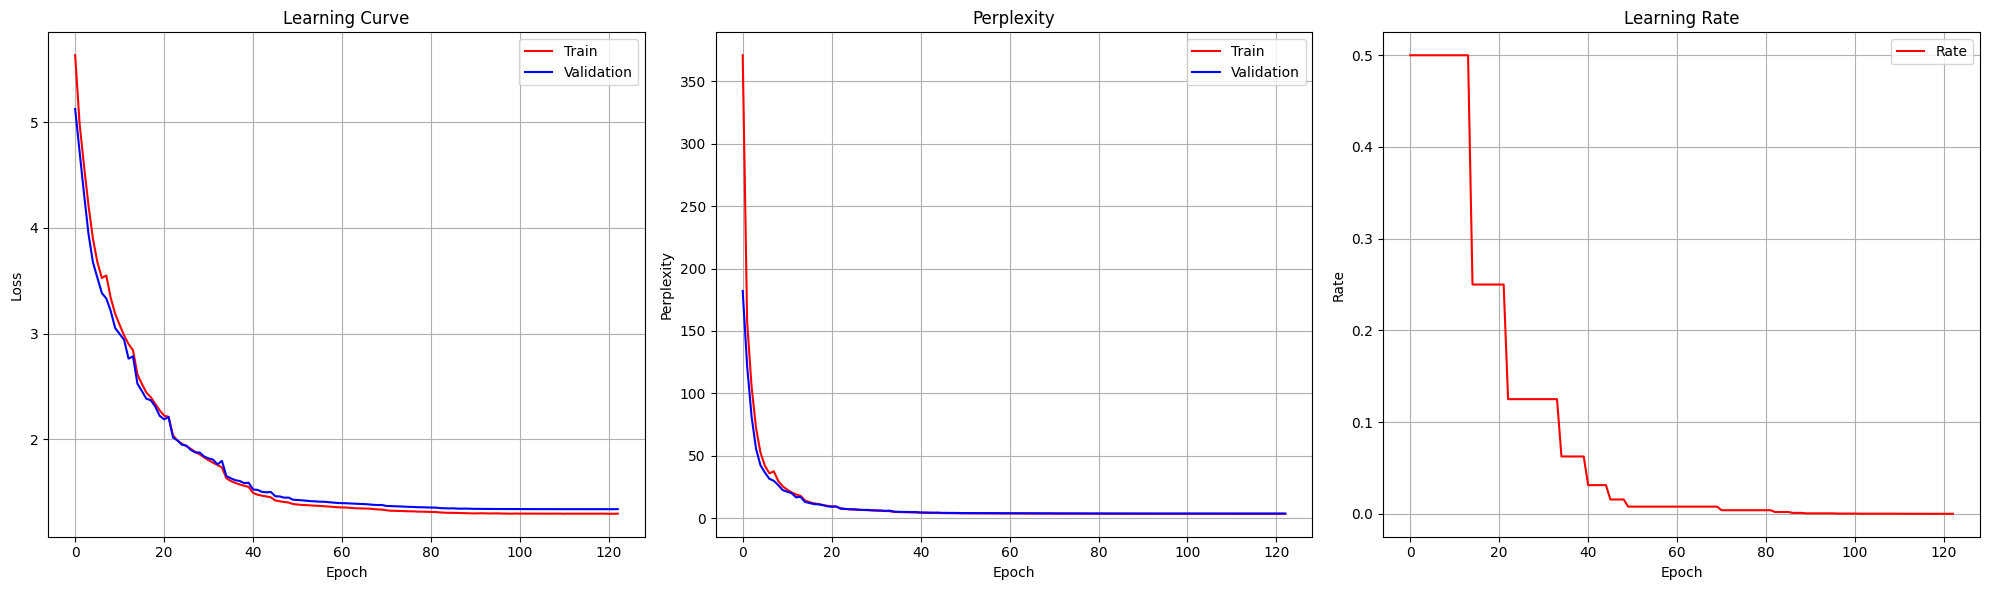

In [24]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [25]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 1.34 , Perplexity = 3.94
Test: Loss = 1.218 , Perplexity = 3.44


# Text Generation

In [26]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(10021, 256)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(256, 256, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(256, 256, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(256, 256, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=10021, bias=True)
)

In [22]:
num_trainable_params(model)

6.719781

In [27]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie of hurt its manufacturing since imports to expand by other buildings and vans nissan spoke to N N of the first time of the year &apos; s &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; and &lt; unk &gt; &lt; unk &gt; &apos; s &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; $ N million in the first quarter the &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; group the company is &lt; unk &gt; and &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; and &lt; unk &gt; &lt; unk
